In [26]:
# ============================================================
# TASK 1: 라이브러리 import 및 환경 설정
# ============================================================

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import sys
import pickle
from datetime import datetime

warnings.filterwarnings('ignore')

# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cpu


In [27]:

# ============================================================
# TASK 2: 데이터 로드 및 피쳐 엔지니어링
# ============================================================

# 데이터 로드
df = pd.read_csv('ecos_monthly_data.csv')
print(f"Data shape: {df.shape}")

# 날짜 컬럼 처리
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date').set_index('date')
elif 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').set_index('Date')

# 타겟 변수 정의
target_columns = [
    'construction_bsi_actual',
    'base_rate', 
    'housing_sale_price',
    'm2_growth',
    'credit_spread'
]

available_targets = [col for col in target_columns if col in df.columns]
print(f"Available target columns: {available_targets}")

# 결측치 처리
df = df.interpolate(method='linear', limit_direction='both')

# 타겟 변수 차분 적용 (비정상성 제거)
for col in available_targets:
    df[f'{col}_diff'] = df[col].diff()

diff_targets = [f'{col}_diff' for col in available_targets]

# 피쳐 엔지니어링: 이동평균, 지연, 변화율
for col in available_targets:
    diff_col = f'{col}_diff'
    
    # 이동평균
    df[f'{diff_col}_ma3'] = df[diff_col].rolling(window=3, min_periods=1).mean()
    df[f'{diff_col}_ma6'] = df[diff_col].rolling(window=6, min_periods=1).mean()
    
    # 변화율
    df[f'{diff_col}_pct_change'] = df[diff_col].pct_change().fillna(0)
    
    # 지연 특징
    for lag in [1, 3, 6]:
        df[f'{diff_col}_lag{lag}'] = df[diff_col].shift(lag)
        df[f'{col}_lag{lag}'] = df[col].shift(lag)

# 결측치 제거
df = df.dropna()

# 피쳐 선택: 상관관계 기반
all_features = [col for col in df.columns if col not in available_targets and col not in diff_targets]

# 높은 상관관계 피쳐 제거
def remove_highly_correlated_features(corr_matrix, threshold=0.95):
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_tri.columns if any(abs(upper_tri[column]) > threshold)]
    return to_drop

correlation_matrix = df[all_features].corr()
highly_corr_features = remove_highly_correlated_features(correlation_matrix)
selected_features = [col for col in all_features if col not in highly_corr_features]

# 타겟과의 상관관계 기반 최종 피쳐 선택
target_correlations = []
for target in diff_targets:
    if target in df.columns:
        corr_with_target = df[selected_features + [target]].corr()[target].abs().sort_values(ascending=False)
        target_correlations.append(corr_with_target[:-1])

avg_correlation = pd.concat(target_correlations, axis=1).mean(axis=1).sort_values(ascending=False)
n_features = max(20, int(len(selected_features) * 0.5))
final_features = avg_correlation.head(n_features).index.tolist()

print(f"Original features: {len(all_features)}")
print(f"Final selected features: {len(final_features)}")

# 최종 데이터 준비
X = df[final_features].values
y = df[diff_targets].values

print(f"Features shape: {X.shape}")
print(f"Targets shape: {y.shape}")

Data shape: (187, 28)
Available target columns: ['construction_bsi_actual', 'base_rate', 'housing_sale_price', 'm2_growth', 'credit_spread']
Original features: 67
Final selected features: 26
Features shape: (180, 26)
Targets shape: (180, 5)


In [30]:
# ============================================================
# TASK 3: 데이터베이스 연결 및 피쳐 저장
# ============================================================

import os
import sys
import mysql.connector
from dotenv import load_dotenv

# DB 폴더의 .env 파일 로드
db_folder = os.path.join(os.path.dirname(os.getcwd()), 'DB')
env_path = os.path.join(db_folder, '.env')
load_dotenv(env_path)

# DB 모듈 import
try:
    from db_query import DatabaseConnection
except ImportError:
    # 노트북에서는 상대 경로를 직접 지정
    import os
    import sys
    
    # modeling 폴더에서 상위 폴더의 DB 폴더로 이동
    parent_dir = os.path.dirname(os.getcwd())
    db_path = os.path.join(parent_dir, 'DB')
    
    if db_path not in sys.path:
        sys.path.insert(0, db_path)
    
    try:
        from db_query import DatabaseConnection
        print(f"DB 모듈 로드 성공: {db_path}")
    except ImportError as e:
        print(f"DB 모듈 로드 실패: {e}")
        DatabaseConnection = None

# DB 폴더의 .env 파일 로드
from dotenv import load_dotenv
parent_dir = os.path.dirname(os.getcwd())
db_folder = os.path.join(parent_dir, 'DB')
env_path = os.path.join(db_folder, '.env')
load_dotenv(env_path)
print(f"DB 설정 로드: {env_path}")

# DB 연결 생성
db_connection = None
if DatabaseConnection:
    try:
        # DatabaseConnection 클래스 인스턴스 생성 (DB 폴더의 .env 사용)
        db_connection = DatabaseConnection()
        if db_connection.connect():
            print("✓ 데이터베이스 연결 성공!")
        else:
            print("✗ 데이터베이스 연결 실패")
            db_connection = None
    except Exception as e:
        print(f"DB 연결 오류: {e}")
        db_connection = None

# 최종 피쳐를 DB에 저장
def save_features_to_db(df_data, db_conn):
    """최종 피쳐를 final_features 테이블에 저장"""
    if not db_conn:
        print("DB 연결 없음 - 파일로만 저장")
        return False
    
    try:
        # 데이터 준비
        df_save = df_data.copy()
        df_save.reset_index(inplace=True)
        df_save['date'] = pd.to_datetime(df_save['date']).dt.strftime('%Y%m')
        
        # DDL 스키마에 맞는 컬럼만 선택
        schema_columns = [
            'date', 'construction_bsi_actual_diff', 'housing_sale_price_diff', 
            'm2_growth_diff', 'credit_spread_diff', 'base_rate_diff',
            'construction_bsi_mom', 'housing_sale_price_diff_ma3', 'm2_growth_lag1',
            'base_rate_mdiff_bp', 'credit_spread_diff_ma3', 'construction_bsi_ma3',
            'leading_index', 'housing_sale_price_diff_lag6', 'construction_bsi_actual_lag3',
            'construction_bsi_actual_diff_ma3', 'base_rate_diff_ma6', 'term_spread',
            'construction_bsi_actual_diff_ma6', 'credit_spread_diff_lag1',
            'market_rate_treasury_bond_3yr', 'credit_spread_diff_ma6', 'base_rate_diff_ma3',
            'base_rate_lag1', 'esi', 'base_rate_diff_lag3', 'm2_growth_diff_ma6'
        ]
        
        available_cols = [col for col in schema_columns if col in df_save.columns]
        df_final = df_save[available_cols].copy()
        
        success = db_conn.save_final_features(df_final)
        return success
        
    except Exception as e:
        print(f"DB 저장 실패: {e}")
        return False

# 피쳐 저장 실행
print("\n" + "=" * 60)
print("최종 피쳐 DB 저장")
print("=" * 60)

save_success = save_features_to_db(df, db_connection)
if save_success:
    print("DB 저장 완료")
else:
    print("DB 저장 실패 - in-memory 데이터로 계속 진행")

DB 설정 로드: c:\Users\baesh\Desktop\kor-ie-proj\DB\.env
MySQL 데이터베이스 연결 성공
✓ 데이터베이스 연결 성공!

최종 피쳐 DB 저장
피쳐 데이터 180건 저장 완료
DB 저장 완료
피쳐 데이터 180건 저장 완료
DB 저장 완료


In [31]:
# ============================================================
# TASK 4: 데이터 준비 함수 및 LSTM 모델 정의
# ============================================================

def create_sequences(X, y, seq_length):
    """시계열 데이터를 LSTM 입력용 시퀀스로 변환"""
    X_seq, y_seq = [], []
    
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i + seq_length])
        y_seq.append(y[i + seq_length])
    
    return np.array(X_seq), np.array(y_seq)

def prepare_data_no_leakage(X, y, seq_length, batch_size, test_size=0.2, val_size=0.1):
    """스케일링 누출을 방지한 데이터 준비"""
    # 시퀀스 생성
    X_seq, y_seq = create_sequences(X, y, seq_length)
    
    # 시간 순서 유지하여 분할
    total_samples = len(X_seq)
    test_start = int(total_samples * (1 - test_size))
    val_start = int(test_start * (1 - val_size))
    
    X_train = X_seq[:val_start]
    y_train = y_seq[:val_start]
    X_val = X_seq[val_start:test_start]
    y_val = y_seq[val_start:test_start]
    X_test = X_seq[test_start:]
    y_test = y_seq[test_start:]
    
    print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
    
    # 스케일링 (train에서만 fit)
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    
    X_train_flat = X_train.reshape(-1, X_train.shape[-1])
    y_train_flat = y_train.reshape(-1, y_train.shape[-1])
    
    scaler_X.fit(X_train_flat)
    scaler_y.fit(y_train_flat)
    
    # 스케일링 적용
    X_train_scaled = np.array([scaler_X.transform(seq) for seq in X_train])
    X_val_scaled = np.array([scaler_X.transform(seq) for seq in X_val])
    X_test_scaled = np.array([scaler_X.transform(seq) for seq in X_test])
    
    y_train_scaled = scaler_y.transform(y_train)
    y_val_scaled = scaler_y.transform(y_val)
    y_test_scaled = scaler_y.transform(y_test)
    
    # Tensor 변환
    X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
    y_train_tensor = torch.FloatTensor(y_train_scaled).to(device)
    X_val_tensor = torch.FloatTensor(X_val_scaled).to(device)
    y_val_tensor = torch.FloatTensor(y_val_scaled).to(device)
    X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
    y_test_tensor = torch.FloatTensor(y_test_scaled).to(device)
    
    # DataLoader 생성
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader, scaler_X, scaler_y

class MultivariateLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate=0.2):
        super(MultivariateLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout_rate if num_layers > 1 else 0,
            batch_first=True
        )
        
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_output = lstm_out[:, -1, :]
        output = self.dropout(last_output)
        output = self.fc(output)
        return output


In [32]:
# ============================================================
# TASK 5: 하이퍼파라미터 튜닝
# ============================================================

def objective_improved(trial):
    """Optuna 목적 함수"""
    params = {
        'hidden_size': trial.suggest_categorical('hidden_size', [32, 64, 96, 128]),
        'num_layers': trial.suggest_int('num_layers', 1, 2),
        'dropout_rate': trial.suggest_float('dropout_rate', 0.1, 0.4, step=0.1),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 5e-3, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64]),
        'seq_length': trial.suggest_categorical('seq_length', [12, 18, 24, 30]),
        'optimizer_type': trial.suggest_categorical('optimizer_type', ['Adam', 'AdamW']),
        'weight_decay': trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True),
        'loss_function': trial.suggest_categorical('loss_function', ['MSE', 'MAE', 'Huber'])
    }
    
    try:
        train_loader, val_loader, _, _, _ = prepare_data_no_leakage(
            X, y, seq_length=params['seq_length'], batch_size=params['batch_size']
        )
        
        model = MultivariateLSTM(
            input_size=X.shape[1],
            hidden_size=params['hidden_size'],
            num_layers=params['num_layers'],
            output_size=y.shape[1],
            dropout_rate=params['dropout_rate']
        ).to(device)
        
        if params['optimizer_type'] == 'Adam':
            optimizer = optim.Adam(model.parameters(), 
                                  lr=params['learning_rate'],
                                  weight_decay=params['weight_decay'])
        else:
            optimizer = optim.AdamW(model.parameters(), 
                                   lr=params['learning_rate'],
                                   weight_decay=params['weight_decay'])
        
        if params['loss_function'] == 'MSE':
            criterion = nn.MSELoss()
        elif params['loss_function'] == 'MAE':
            criterion = nn.L1Loss()
        else:
            criterion = nn.HuberLoss(delta=1.0)
        
        best_val_loss = float('inf')
        patience = 0
        max_patience = 10
        
        for epoch in range(30):
            model.train()
            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
            
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for batch_X, batch_y in val_loader:
                    outputs = model(batch_X)
                    loss = criterion(outputs, batch_y)
                    val_loss += loss.item()
            
            avg_val_loss = val_loss / len(val_loader)
            
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                patience = 0
            else:
                patience += 1
                if patience >= max_patience:
                    break
            
            trial.report(avg_val_loss, epoch)
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()
        
        return best_val_loss
        
    except Exception as e:
        print(f"Trial failed: {e}")
        return float('inf')

print("\n" + "=" * 60)
print("하이퍼파라미터 최적화 시작")
print("=" * 60)

study = optuna.create_study(
    direction='minimize',
    pruner=optuna.pruners.MedianPruner(n_startup_trials=3, n_warmup_steps=5)
)

study.optimize(objective_improved, n_trials=30, timeout=600)

best_trial = study.best_trial
best_params = best_trial.params

print("\nBest Hyperparameters:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

[I 2025-09-22 15:34:35,909] A new study created in memory with name: no-name-7a47e0e5-00cc-44b2-976b-956075fbfe78



하이퍼파라미터 최적화 시작
Train: 116, Val: 13, Test: 33


[I 2025-09-22 15:34:37,630] Trial 0 finished with value: 0.6995552182197571 and parameters: {'hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0.1, 'learning_rate': 0.001173521779255875, 'batch_size': 16, 'seq_length': 18, 'optimizer_type': 'AdamW', 'weight_decay': 2.3517539004966906e-05, 'loss_function': 'Huber'}. Best is trial 0 with value: 0.6995552182197571.


Train: 116, Val: 13, Test: 33


[I 2025-09-22 15:34:38,489] Trial 1 finished with value: 0.6674367785453796 and parameters: {'hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.2, 'learning_rate': 0.000464195061974123, 'batch_size': 32, 'seq_length': 18, 'optimizer_type': 'AdamW', 'weight_decay': 1.3974503886822306e-05, 'loss_function': 'Huber'}. Best is trial 1 with value: 0.6674367785453796.


Train: 111, Val: 13, Test: 32


[I 2025-09-22 15:34:39,079] Trial 2 finished with value: 2.2188596725463867 and parameters: {'hidden_size': 96, 'num_layers': 1, 'dropout_rate': 0.1, 'learning_rate': 0.0035424898346036638, 'batch_size': 32, 'seq_length': 24, 'optimizer_type': 'AdamW', 'weight_decay': 0.00016151283351741608, 'loss_function': 'MSE'}. Best is trial 1 with value: 0.6674367785453796.


Train: 111, Val: 13, Test: 32


[I 2025-09-22 15:34:39,412] Trial 3 finished with value: inf and parameters: {'hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.000471375296483396, 'batch_size': 64, 'seq_length': 24, 'optimizer_type': 'Adam', 'weight_decay': 4.025954416269065e-05, 'loss_function': 'MAE'}. Best is trial 1 with value: 0.6674367785453796.


Trial failed: 
Train: 111, Val: 13, Test: 32


[I 2025-09-22 15:34:40,412] Trial 4 finished with value: inf and parameters: {'hidden_size': 96, 'num_layers': 2, 'dropout_rate': 0.1, 'learning_rate': 0.0002892455016203135, 'batch_size': 16, 'seq_length': 24, 'optimizer_type': 'Adam', 'weight_decay': 1.9773337878280376e-05, 'loss_function': 'MSE'}. Best is trial 1 with value: 0.6674367785453796.


Trial failed: 
Train: 120, Val: 14, Test: 34


[I 2025-09-22 15:34:40,629] Trial 5 finished with value: inf and parameters: {'hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.000920853729232502, 'batch_size': 32, 'seq_length': 12, 'optimizer_type': 'AdamW', 'weight_decay': 0.00016281527942810912, 'loss_function': 'Huber'}. Best is trial 1 with value: 0.6674367785453796.


Trial failed: 
Train: 111, Val: 13, Test: 32


[I 2025-09-22 15:34:41,595] Trial 6 finished with value: inf and parameters: {'hidden_size': 96, 'num_layers': 2, 'dropout_rate': 0.1, 'learning_rate': 0.0039430251228458005, 'batch_size': 16, 'seq_length': 24, 'optimizer_type': 'Adam', 'weight_decay': 0.00010372084113167201, 'loss_function': 'MSE'}. Best is trial 1 with value: 0.6674367785453796.


Trial failed: 
Train: 111, Val: 13, Test: 32


[I 2025-09-22 15:34:41,944] Trial 7 finished with value: inf and parameters: {'hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0.1, 'learning_rate': 0.003056733645894255, 'batch_size': 16, 'seq_length': 24, 'optimizer_type': 'AdamW', 'weight_decay': 0.00019990980214827644, 'loss_function': 'MSE'}. Best is trial 1 with value: 0.6674367785453796.


Trial failed: 
Train: 116, Val: 13, Test: 33


[I 2025-09-22 15:34:42,534] Trial 8 finished with value: inf and parameters: {'hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.4, 'learning_rate': 0.0007121830707151748, 'batch_size': 16, 'seq_length': 18, 'optimizer_type': 'Adam', 'weight_decay': 1.07959527721907e-05, 'loss_function': 'MAE'}. Best is trial 1 with value: 0.6674367785453796.


Trial failed: 
Train: 116, Val: 13, Test: 33


[I 2025-09-22 15:34:43,161] Trial 9 finished with value: 0.7068002820014954 and parameters: {'hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0.1, 'learning_rate': 0.004637051586696395, 'batch_size': 16, 'seq_length': 18, 'optimizer_type': 'Adam', 'weight_decay': 2.541182869011549e-05, 'loss_function': 'Huber'}. Best is trial 1 with value: 0.6674367785453796.


Train: 108, Val: 12, Test: 30


[I 2025-09-22 15:34:43,661] Trial 10 finished with value: inf and parameters: {'hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.2, 'learning_rate': 0.00011016845472702568, 'batch_size': 32, 'seq_length': 30, 'optimizer_type': 'AdamW', 'weight_decay': 0.00043532314582672254, 'loss_function': 'Huber'}. Best is trial 1 with value: 0.6674367785453796.


Trial failed: 
Train: 116, Val: 13, Test: 33


[I 2025-09-22 15:34:44,477] Trial 11 finished with value: 0.6761097311973572 and parameters: {'hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.2, 'learning_rate': 0.001393558833821423, 'batch_size': 64, 'seq_length': 18, 'optimizer_type': 'AdamW', 'weight_decay': 4.752505698178598e-05, 'loss_function': 'Huber'}. Best is trial 1 with value: 0.6674367785453796.


Train: 116, Val: 13, Test: 33


[I 2025-09-22 15:34:45,263] Trial 12 finished with value: 0.6760041117668152 and parameters: {'hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.2, 'learning_rate': 0.0017387695737687994, 'batch_size': 64, 'seq_length': 18, 'optimizer_type': 'AdamW', 'weight_decay': 4.960702471570479e-05, 'loss_function': 'Huber'}. Best is trial 1 with value: 0.6674367785453796.


Train: 116, Val: 13, Test: 33


[I 2025-09-22 15:34:46,929] Trial 13 finished with value: 0.6792649626731873 and parameters: {'hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.2, 'learning_rate': 0.0002807256594912988, 'batch_size': 64, 'seq_length': 18, 'optimizer_type': 'AdamW', 'weight_decay': 1.0778545256492434e-05, 'loss_function': 'Huber'}. Best is trial 1 with value: 0.6674367785453796.


Train: 120, Val: 14, Test: 34


[I 2025-09-22 15:34:47,351] Trial 14 finished with value: 0.7395891547203064 and parameters: {'hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0018790449696355076, 'batch_size': 64, 'seq_length': 12, 'optimizer_type': 'AdamW', 'weight_decay': 5.9828576087861006e-05, 'loss_function': 'Huber'}. Best is trial 1 with value: 0.6674367785453796.


Train: 108, Val: 12, Test: 30


[I 2025-09-22 15:34:48,422] Trial 15 finished with value: inf and parameters: {'hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.2, 'learning_rate': 0.00044780487500867077, 'batch_size': 32, 'seq_length': 30, 'optimizer_type': 'AdamW', 'weight_decay': 7.287136801989142e-05, 'loss_function': 'Huber'}. Best is trial 1 with value: 0.6674367785453796.


Trial failed: 
Train: 116, Val: 13, Test: 33


[I 2025-09-22 15:34:48,696] Trial 16 finished with value: inf and parameters: {'hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.2, 'learning_rate': 0.0021036728574841536, 'batch_size': 64, 'seq_length': 18, 'optimizer_type': 'AdamW', 'weight_decay': 0.0005355195915806553, 'loss_function': 'MAE'}. Best is trial 1 with value: 0.6674367785453796.


Trial failed: 
Train: 116, Val: 13, Test: 33


[I 2025-09-22 15:34:50,547] Trial 17 finished with value: 0.6956239342689514 and parameters: {'hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.4, 'learning_rate': 0.0004546552765611071, 'batch_size': 32, 'seq_length': 18, 'optimizer_type': 'AdamW', 'weight_decay': 0.0008959157394006392, 'loss_function': 'Huber'}. Best is trial 1 with value: 0.6674367785453796.


Train: 116, Val: 13, Test: 33


[I 2025-09-22 15:34:53,491] Trial 18 finished with value: 0.6502213478088379 and parameters: {'hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.00016971447852918693, 'batch_size': 32, 'seq_length': 18, 'optimizer_type': 'AdamW', 'weight_decay': 1.654285838698586e-05, 'loss_function': 'Huber'}. Best is trial 18 with value: 0.6502213478088379.


Train: 108, Val: 12, Test: 30


[I 2025-09-22 15:34:53,902] Trial 19 finished with value: inf and parameters: {'hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.00011616111784524306, 'batch_size': 32, 'seq_length': 30, 'optimizer_type': 'AdamW', 'weight_decay': 1.4407050156777279e-05, 'loss_function': 'MAE'}. Best is trial 18 with value: 0.6502213478088379.


Trial failed: 
Train: 120, Val: 14, Test: 34


[I 2025-09-22 15:34:55,157] Trial 20 finished with value: inf and parameters: {'hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.4, 'learning_rate': 0.00018583892241336552, 'batch_size': 32, 'seq_length': 12, 'optimizer_type': 'AdamW', 'weight_decay': 3.0000818545077867e-05, 'loss_function': 'Huber'}. Best is trial 18 with value: 0.6502213478088379.


Trial failed: 
Train: 116, Val: 13, Test: 33


[I 2025-09-22 15:34:57,992] Trial 21 finished with value: 0.6678630113601685 and parameters: {'hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0001682213893905449, 'batch_size': 32, 'seq_length': 18, 'optimizer_type': 'AdamW', 'weight_decay': 1.6235306743960168e-05, 'loss_function': 'Huber'}. Best is trial 18 with value: 0.6502213478088379.


Train: 116, Val: 13, Test: 33


[I 2025-09-22 15:34:59,525] Trial 22 finished with value: inf and parameters: {'hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.00018425216757790157, 'batch_size': 32, 'seq_length': 18, 'optimizer_type': 'AdamW', 'weight_decay': 1.595702300214996e-05, 'loss_function': 'Huber'}. Best is trial 18 with value: 0.6502213478088379.


Trial failed: 
Train: 116, Val: 13, Test: 33


[I 2025-09-22 15:35:01,160] Trial 23 finished with value: inf and parameters: {'hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.00021398761772243593, 'batch_size': 32, 'seq_length': 18, 'optimizer_type': 'AdamW', 'weight_decay': 3.2649322733740305e-05, 'loss_function': 'Huber'}. Best is trial 18 with value: 0.6502213478088379.


Trial failed: 
Train: 116, Val: 13, Test: 33


[I 2025-09-22 15:35:02,871] Trial 24 finished with value: 0.6937964558601379 and parameters: {'hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0003442310718051073, 'batch_size': 32, 'seq_length': 18, 'optimizer_type': 'AdamW', 'weight_decay': 1.539331135462247e-05, 'loss_function': 'Huber'}. Best is trial 18 with value: 0.6502213478088379.


Train: 116, Val: 13, Test: 33


[I 2025-09-22 15:35:05,687] Trial 25 finished with value: 0.67255038022995 and parameters: {'hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.4, 'learning_rate': 0.00014103349614261635, 'batch_size': 32, 'seq_length': 18, 'optimizer_type': 'AdamW', 'weight_decay': 1.0006507068107189e-05, 'loss_function': 'Huber'}. Best is trial 18 with value: 0.6502213478088379.


Train: 116, Val: 13, Test: 33


[I 2025-09-22 15:35:07,230] Trial 26 finished with value: 0.6538231372833252 and parameters: {'hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.000164824565629874, 'batch_size': 32, 'seq_length': 18, 'optimizer_type': 'Adam', 'weight_decay': 1.912294102309648e-05, 'loss_function': 'Huber'}. Best is trial 18 with value: 0.6502213478088379.


Train: 116, Val: 13, Test: 33


[I 2025-09-22 15:35:07,869] Trial 27 finished with value: 0.7104383111000061 and parameters: {'hidden_size': 96, 'num_layers': 1, 'dropout_rate': 0.2, 'learning_rate': 0.0006229803803010333, 'batch_size': 32, 'seq_length': 18, 'optimizer_type': 'Adam', 'weight_decay': 9.001586596938099e-05, 'loss_function': 'Huber'}. Best is trial 18 with value: 0.6502213478088379.
[I 2025-09-22 15:35:08,053] Trial 28 finished with value: inf and parameters: {'hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.00023709780841095506, 'batch_size': 32, 'seq_length': 12, 'optimizer_type': 'Adam', 'weight_decay': 3.493749563877165e-05, 'loss_function': 'MSE'}. Best is trial 18 with value: 0.6502213478088379.
[I 2025-09-22 15:35:08,053] Trial 28 finished with value: inf and parameters: {'hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.00023709780841095506, 'batch_size': 32, 'seq_length': 12, 'optimizer_type': 'Adam', 'weight_d

Train: 120, Val: 14, Test: 34
Trial failed: 
Train: 116, Val: 13, Test: 33
Train: 116, Val: 13, Test: 33


[I 2025-09-22 15:35:08,290] Trial 29 finished with value: inf and parameters: {'hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0.4, 'learning_rate': 0.0001328723462599631, 'batch_size': 32, 'seq_length': 18, 'optimizer_type': 'Adam', 'weight_decay': 2.2309676391728152e-05, 'loss_function': 'MAE'}. Best is trial 18 with value: 0.6502213478088379.


Trial failed: 

Best Hyperparameters:
  hidden_size: 128
  num_layers: 2
  dropout_rate: 0.30000000000000004
  learning_rate: 0.00016971447852918693
  batch_size: 32
  seq_length: 18
  optimizer_type: AdamW
  weight_decay: 1.654285838698586e-05
  loss_function: Huber


In [33]:
# ============================================================
# TASK 6: 최적 모델 학습
# ============================================================

print("\n" + "=" * 60)
print("최적 모델 학습")
print("=" * 60)

# 데이터 준비
train_loader, val_loader, test_loader, scaler_X, scaler_y = prepare_data_no_leakage(
    X, y, seq_length=best_params['seq_length'], batch_size=best_params['batch_size']
)

# 최적 모델 생성
final_model = MultivariateLSTM(
    input_size=X.shape[1],
    hidden_size=best_params['hidden_size'],
    num_layers=best_params['num_layers'],
    output_size=y.shape[1],
    dropout_rate=best_params['dropout_rate']
).to(device)

# 옵티마이저 및 손실함수 설정
if best_params['optimizer_type'] == 'Adam':
    optimizer = optim.Adam(final_model.parameters(), 
                          lr=best_params['learning_rate'],
                          weight_decay=best_params['weight_decay'])
else:
    optimizer = optim.AdamW(final_model.parameters(), 
                           lr=best_params['learning_rate'],
                           weight_decay=best_params['weight_decay'])

if best_params['loss_function'] == 'MSE':
    criterion = nn.MSELoss()
elif best_params['loss_function'] == 'MAE':
    criterion = nn.L1Loss()
else:
    criterion = nn.HuberLoss(delta=1.0)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

# 모델 학습
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0
max_patience = 20
best_model_state = None

for epoch in range(200):
    # Training
    final_model.train()
    train_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = final_model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(final_model.parameters(), 1.0)
        optimizer.step()
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation
    final_model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = final_model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    scheduler.step(avg_val_loss)
    
    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        best_model_state = final_model.state_dict().copy()
        print(f"Epoch {epoch+1:3d}: Train={avg_train_loss:.6f}, Val={avg_val_loss:.6f}")
    else:
        patience_counter += 1
        if epoch % 10 == 0 or patience_counter >= max_patience:
            print(f"Epoch {epoch+1:3d}: Train={avg_train_loss:.6f}, Val={avg_val_loss:.6f} ({patience_counter}/{max_patience})")
    
    if patience_counter >= max_patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

# 최적 가중치 복원
if best_model_state is not None:
    final_model.load_state_dict(best_model_state)
    print(f"Best model restored with validation loss: {best_val_loss:.6f}")


최적 모델 학습
Train: 116, Val: 13, Test: 33
Epoch   1: Train=0.346482, Val=0.728759
Epoch   2: Train=0.335865, Val=0.723681
Epoch   3: Train=0.333709, Val=0.718547
Epoch   2: Train=0.335865, Val=0.723681
Epoch   3: Train=0.333709, Val=0.718547
Epoch   4: Train=0.338444, Val=0.713233
Epoch   5: Train=0.333564, Val=0.707812
Epoch   4: Train=0.338444, Val=0.713233
Epoch   5: Train=0.333564, Val=0.707812
Epoch   6: Train=0.333351, Val=0.702277
Epoch   7: Train=0.321657, Val=0.696587
Epoch   6: Train=0.333351, Val=0.702277
Epoch   7: Train=0.321657, Val=0.696587
Epoch   8: Train=0.318841, Val=0.691007
Epoch   9: Train=0.326937, Val=0.685058
Epoch   8: Train=0.318841, Val=0.691007
Epoch   9: Train=0.326937, Val=0.685058
Epoch  10: Train=0.317793, Val=0.679288
Epoch  11: Train=0.309920, Val=0.673601
Epoch  10: Train=0.317793, Val=0.679288
Epoch  11: Train=0.309920, Val=0.673601
Epoch  12: Train=0.305148, Val=0.668815
Epoch  13: Train=0.301330, Val=0.668017
Epoch  12: Train=0.305148, Val=0.668815


In [34]:
# ============================================================
# TASK 7: 모델 평가
# ============================================================

print("\n" + "=" * 60)
print("모델 평가")
print("=" * 60)

final_model.eval()
test_predictions = []
test_targets = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = final_model(batch_X)
        test_predictions.append(outputs.cpu().numpy())
        test_targets.append(batch_y.cpu().numpy())

test_predictions = np.vstack(test_predictions)
test_targets = np.vstack(test_targets)

# 역정규화
test_predictions_diff = scaler_y.inverse_transform(test_predictions)
test_targets_diff = scaler_y.inverse_transform(test_targets)

# 성능 메트릭 계산
test_metrics = {}
for i, target in enumerate(available_targets):
    if i < test_predictions_diff.shape[1]:
        rmse = np.sqrt(mean_squared_error(test_targets_diff[:, i], test_predictions_diff[:, i]))
        mae = mean_absolute_error(test_targets_diff[:, i], test_predictions_diff[:, i])
        
        test_metrics[target] = {'RMSE': rmse, 'MAE': mae}
        print(f"{target}: RMSE={rmse:.4f}, MAE={mae:.4f}")


모델 평가
construction_bsi_actual: RMSE=2.0347, MAE=1.5177
base_rate: RMSE=0.0941, MAE=0.0489
housing_sale_price: RMSE=0.3818, MAE=0.2202
m2_growth: RMSE=0.4891, MAE=0.3654
credit_spread: RMSE=0.0787, MAE=0.0512


In [35]:
# ============================================================
# TASK 8: 재귀적 미래 예측 (3개월)
# ============================================================

def predict_future_recursive(model, df_original, scaler_X, scaler_y, final_features, seq_length, n_months=3):
    """재귀적 미래 예측 - 각 단계의 예측값으로 다음 피쳐를 업데이트"""
    model.eval()
    
    # 현재 데이터 복사
    df_pred = df_original.copy()
    future_predictions = []
    
    for month in range(n_months):
        print(f"\n=== Month {month+1} Prediction ===")
        
        # 현재 시점의 마지막 시퀀스 추출
        current_features = df_pred[final_features].iloc[-seq_length:].values
        current_features_scaled = scaler_X.transform(current_features)
        
        # 예측 수행
        with torch.no_grad():
            X_tensor = torch.FloatTensor(current_features_scaled).unsqueeze(0).to(device)
            pred_scaled = model(X_tensor).cpu().numpy()
            pred_diff = scaler_y.inverse_transform(pred_scaled)[0]
        
        # 차분값을 원시값으로 변환
        last_original_values = df_pred[available_targets].iloc[-1].values
        predicted_values = last_original_values + pred_diff
        
        future_predictions.append(predicted_values.copy())
        print(f"Predicted diff: {pred_diff}")
        print(f"Predicted values: {predicted_values}")
        
        # 다음 예측을 위해 DataFrame 업데이트
        next_date = df_pred.index[-1] + pd.DateOffset(months=1)
        
        # 새로운 행 생성 (기본값으로 초기화)
        new_row = df_pred.iloc[-1].copy()
        
        # 타겟 변수 업데이트
        for i, target in enumerate(available_targets):
            new_row[target] = predicted_values[i]
            new_row[f'{target}_diff'] = pred_diff[i]
        
        # 지연 변수 업데이트 (lag features)
        for target in available_targets:
            if f'{target}_lag1' in new_row.index:
                new_row[f'{target}_lag1'] = df_pred[target].iloc[-1]
            if f'{target}_lag3' in new_row.index:
                new_row[f'{target}_lag3'] = df_pred[target].iloc[-3] if len(df_pred) >= 3 else df_pred[target].iloc[0]
            if f'{target}_lag6' in new_row.index:
                new_row[f'{target}_lag6'] = df_pred[target].iloc[-6] if len(df_pred) >= 6 else df_pred[target].iloc[0]
        
        # 이동평균 업데이트 (간단화된 버전)
        for target in available_targets:
            diff_col = f'{target}_diff'
            if f'{diff_col}_ma3' in new_row.index:
                recent_diffs = df_pred[diff_col].iloc[-2:].tolist() + [pred_diff[available_targets.index(target)]]
                new_row[f'{diff_col}_ma3'] = np.mean(recent_diffs)
            if f'{diff_col}_ma6' in new_row.index:
                recent_diffs = df_pred[diff_col].iloc[-5:].tolist() + [pred_diff[available_targets.index(target)]]
                new_row[f'{diff_col}_ma6'] = np.mean(recent_diffs)
        
        # DataFrame에 새로운 행 추가
        new_row.name = next_date
        df_pred = pd.concat([df_pred, new_row.to_frame().T])
        
        print(f"Updated DataFrame shape: {df_pred.shape}")
    
    return np.array(future_predictions)

print("\n" + "=" * 60)
print("재귀적 미래 예측 (3개월)")
print("=" * 60)

# 재귀적 예측 수행
future_predictions_recursive = predict_future_recursive(
    final_model, df, scaler_X, scaler_y, final_features, 
    best_params['seq_length'], n_months=3
)

# 예측 결과를 DataFrame으로 변환
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=3, freq='MS')

predictions_df = pd.DataFrame(
    future_predictions_recursive,
    columns=available_targets,
    index=future_dates
)

print("\n미래 3개월 예측 결과:")
print(predictions_df)

# 최근 실제값과 비교
print("\n최근 실제값 (비교용):")
recent_values = df[available_targets].tail(3)
print(recent_values)



재귀적 미래 예측 (3개월)

=== Month 1 Prediction ===
Predicted diff: [ 0.51702553 -0.01284476  0.09047793 -0.00338212  0.01790408]
Predicted values: [69.51702553  2.48715524 93.44747793  0.99661788  5.85590408]
Updated DataFrame shape: (181, 77)

=== Month 2 Prediction ===
Predicted diff: [ 0.46508372 -0.01271614  0.11615155 -0.00397822  0.01608628]
Predicted values: [69.98210925  2.4744391  93.56362948  0.99263966  5.87199036]
Updated DataFrame shape: (182, 77)

=== Month 3 Prediction ===
Predicted diff: [ 0.4049678  -0.01270413  0.13960257 -0.00274543  0.01440301]
Predicted values: [70.38707706  2.46173496 93.70323205  0.98989423  5.88639337]
Updated DataFrame shape: (183, 77)

미래 3개월 예측 결과:
            construction_bsi_actual  base_rate  housing_sale_price  m2_growth  \
2025-09-01                69.517026   2.487155           93.447478   0.996618   
2025-10-01                69.982109   2.474439           93.563629   0.992640   
2025-11-01                70.387077   2.461735           93.70

In [36]:
# ============================================================
# TASK 9: 예측 결과 DB 저장
# ============================================================

def save_predictions_to_db(predictions_df, db_conn):
    """예측 결과를 model_output 테이블에 저장"""
    if not db_conn:
        print("DB 연결 없음 - 파일로만 저장")
        return False
    
    try:
        # 데이터 준비 (DDL 스키마에 맞춤)
        pred_save = predictions_df.copy()
        pred_save.reset_index(inplace=True)
        
        # 인덱스 컬럼명을 'date'로 변경
        if 'index' in pred_save.columns:
            pred_save.rename(columns={'index': 'date'}, inplace=True)
        
        pred_save['date'] = pd.to_datetime(pred_save['date']).dt.strftime('%Y%m')
        
        # credit_spread 컬럼 추가 (없는 경우)
        if 'credit_spread' not in pred_save.columns:
            pred_save['credit_spread'] = 0.0
        
        success = db_conn.save_model_output(pred_save)
        return success
        
    except Exception as e:
        print(f"예측 결과 저장 실패: {e}")
        return False

print("\n" + "=" * 60)
print("예측 결과 DB 저장")
print("=" * 60)

pred_save_success = save_predictions_to_db(predictions_df, db_connection)
if pred_save_success:
    print("예측 결과 DB 저장 완료")
else:
    print("예측 결과 저장 실패")


예측 결과 DB 저장
모델 예측 결과 3건 저장 완료
예측 결과 DB 저장 완료


In [37]:
# ============================================================
# TASK 10: 모델 아티팩트 저장
# ============================================================

def save_model_artifacts(artifacts, filepath='output/lstm_model_artifacts.pkl'):
    """모델 아티팩트를 파일로 저장"""
    try:
        with open(filepath, 'wb') as f:
            pickle.dump(artifacts, f)
        print(f"모델 아티팩트 저장: {filepath}")
        return True
    except Exception as e:
        print(f"아티팩트 저장 실패: {e}")
        return False

print("\n" + "=" * 60)
print("모델 아티팩트 저장")
print("=" * 60)

# 베이스라인 메트릭 (간단한 버전)
baseline_metrics = {}
for target in available_targets:
    naive_pred = np.full(len(test_targets_diff), df[target].iloc[-1])
    if len(test_targets_diff) > 0:
        target_idx = available_targets.index(target)
        rmse = np.sqrt(mean_squared_error(test_targets_diff[:, target_idx], naive_pred))
        baseline_metrics[f'{target}_naive_rmse'] = rmse

# 아티팩트 구성
artifacts = {
    "model_state_dict": {k: v.cpu() for k, v in final_model.state_dict().items()},
    "hyperparameters": best_params,
    "scaler_X": scaler_X,
    "scaler_y": scaler_y,
    "final_features": final_features,
    "target_columns": available_targets,
    "test_metrics": test_metrics,
    "baseline_metrics": baseline_metrics,
    "training_losses": train_losses,
    "validation_losses": val_losses
}

artifact_saved = save_model_artifacts(artifacts, os.path.join('output', 'lstm_model_artifacts.pkl'))


모델 아티팩트 저장
모델 아티팩트 저장: output\lstm_model_artifacts.pkl



결과 파일 저장
예측 결과 저장: output/lstm_predictions_3months.csv
성능 메트릭 저장: output/lstm_performance_metrics.csv
모델 체크포인트 저장: output/lstm_model_checkpoint.pth

시각화


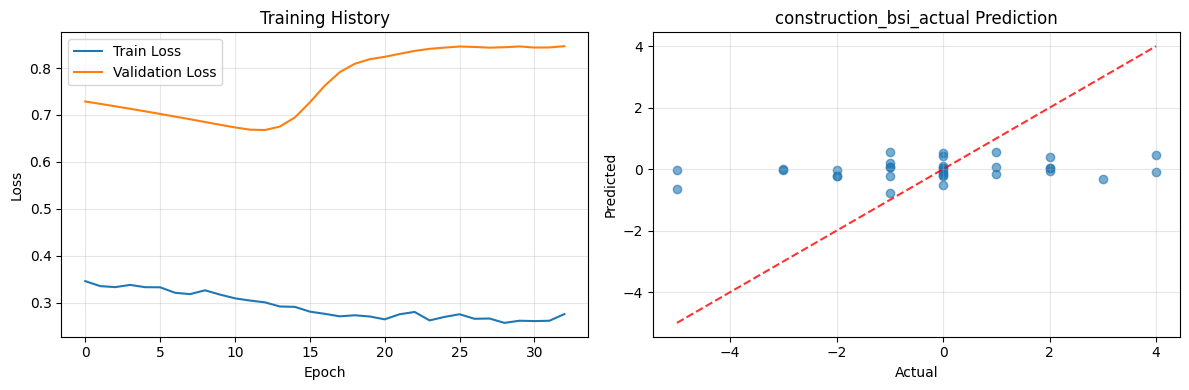

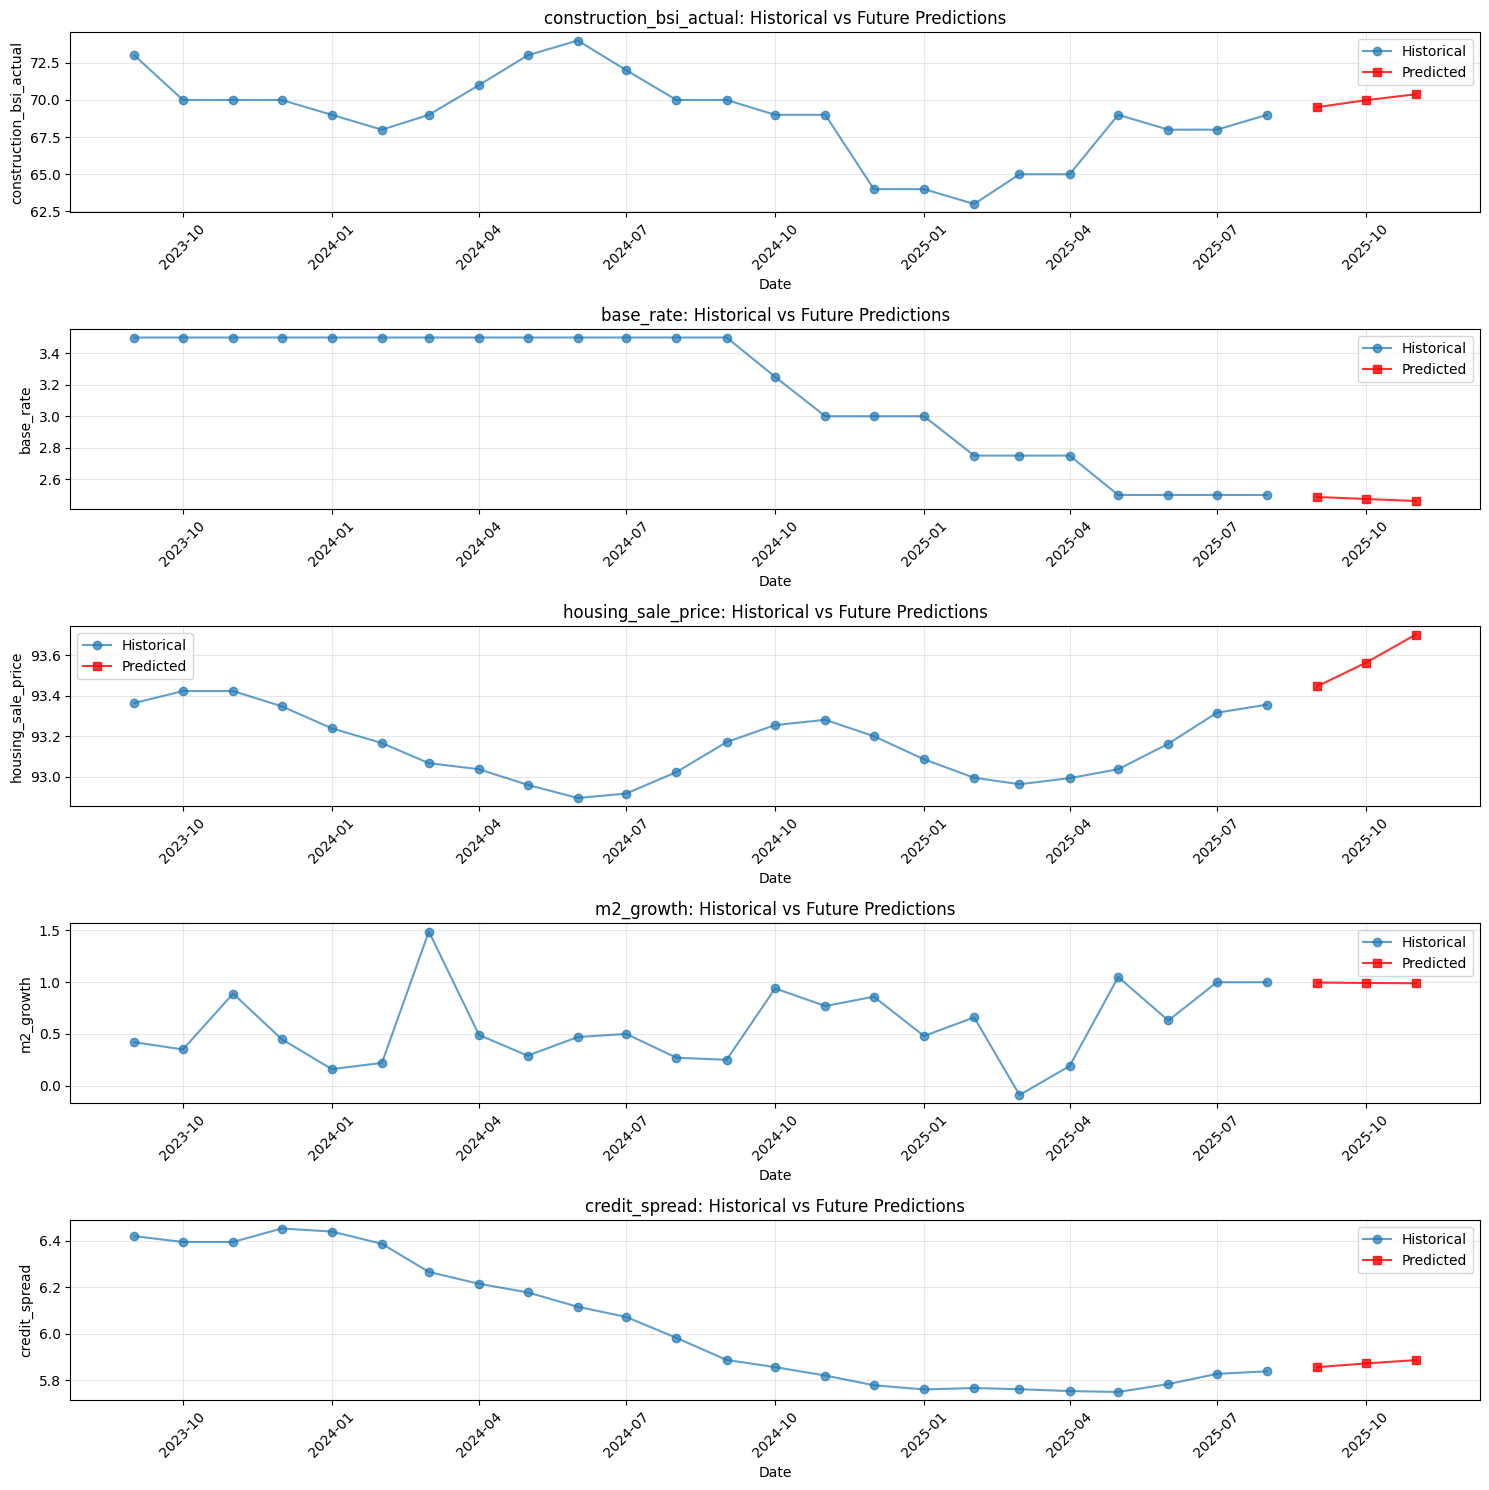

In [39]:
# ============================================================
# TASK 11: 결과 파일 저장 및 시각화
# ============================================================

print("\n" + "=" * 60)
print("결과 파일 저장")
print("=" * 60)

# output 폴더 생성
import os
output_dir = 'output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"✓ {output_dir} 폴더 생성")

try:
    # 예측 결과 저장
    predictions_df.to_csv(os.path.join(output_dir, 'lstm_predictions_3months.csv'))
    print(f"예측 결과 저장: {output_dir}/lstm_predictions_3months.csv")
    
    # 성능 메트릭 저장
    metrics_df = pd.DataFrame(test_metrics).T
    metrics_df.to_csv(os.path.join(output_dir, 'lstm_performance_metrics.csv'))
    print(f"성능 메트릭 저장: {output_dir}/lstm_performance_metrics.csv")
    
    # 모델 체크포인트 저장
    torch.save({
        'model_state_dict': final_model.state_dict(),
        'hyperparameters': best_params,
        'scaler_X': scaler_X,
        'scaler_y': scaler_y
    }, os.path.join(output_dir, 'lstm_model_checkpoint.pth'))
    print(f"모델 체크포인트 저장: {output_dir}/lstm_model_checkpoint.pth")
    
except Exception as e:
    print(f"파일 저장 오류: {e}")

# 간단한 시각화
print("\n" + "=" * 60)
print("시각화")
print("=" * 60)

# 학습 곡선
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.grid(True, alpha=0.3)

# 예측 vs 실제 (첫 번째 타겟만)
plt.subplot(1, 2, 2)
if len(test_predictions_diff) > 0 and len(available_targets) > 0:
    target_idx = 0
    plt.scatter(test_targets_diff[:, target_idx], test_predictions_diff[:, target_idx], alpha=0.6)
    min_val = min(test_targets_diff[:, target_idx].min(), test_predictions_diff[:, target_idx].min())
    max_val = max(test_targets_diff[:, target_idx].max(), test_predictions_diff[:, target_idx].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{available_targets[0]} Prediction')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 미래 예측 시각화
plt.figure(figsize=(15, 3*len(available_targets)))
for i, target in enumerate(available_targets):
    plt.subplot(len(available_targets), 1, i+1)
    
    # 최근 24개월 실제 데이터
    recent_data = df[target].tail(24)
    future_data = predictions_df[target]
    
    plt.plot(recent_data.index, recent_data.values, 'o-', label='Historical', alpha=0.7)
    plt.plot(future_data.index, future_data.values, 's-', label='Predicted', color='red', alpha=0.8)
    
    plt.xlabel('Date')
    plt.ylabel(target)
    plt.title(f'{target}: Historical vs Future Predictions')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [40]:
# ============================================================
# TASK 12: 최종 정리 및 DB 연결 종료
# ============================================================

print("\n" + "=" * 60)
print("LSTM 모델링 파이프라인 완료")
print("=" * 60)

print("생성된 파일:")
print("  • output/lstm_predictions_3months.csv")
print("  • output/lstm_performance_metrics.csv") 
print("  • output/lstm_model_checkpoint.pth")
print("  • output/lstm_model_artifacts.pkl")

print(f"\n최종 성능:")
for target, metrics in test_metrics.items():
    print(f"  {target}: RMSE = {metrics['RMSE']:.4f}, MAE = {metrics['MAE']:.4f}")

print(f"\n예측 결과 요약:")
for i, target in enumerate(available_targets):
    last_actual = df[target].iloc[-1]
    pred_values = predictions_df[target].values
    avg_change = np.mean(pred_values - last_actual)
    print(f"  {target}: 현재 {last_actual:.3f} → 3개월 후 평균 {np.mean(pred_values):.3f} (변화: {avg_change:+.3f})")

# DB 연결 정리
if db_connection:
    db_connection.disconnect()
    print("\nDB 연결 종료 완료")

print("\n" + "=" * 60)


LSTM 모델링 파이프라인 완료
생성된 파일:
  • output/lstm_predictions_3months.csv
  • output/lstm_performance_metrics.csv
  • output/lstm_model_checkpoint.pth
  • output/lstm_model_artifacts.pkl

최종 성능:
  construction_bsi_actual: RMSE = 2.0347, MAE = 1.5177
  base_rate: RMSE = 0.0941, MAE = 0.0489
  housing_sale_price: RMSE = 0.3818, MAE = 0.2202
  m2_growth: RMSE = 0.4891, MAE = 0.3654
  credit_spread: RMSE = 0.0787, MAE = 0.0512

예측 결과 요약:
  construction_bsi_actual: 현재 69.000 → 3개월 후 평균 69.962 (변화: +0.962)
  base_rate: 현재 2.500 → 3개월 후 평균 2.474 (변화: -0.026)
  housing_sale_price: 현재 93.357 → 3개월 후 평균 93.571 (변화: +0.214)
  m2_growth: 현재 1.000 → 3개월 후 평균 0.993 (변화: -0.007)
  credit_spread: 현재 5.838 → 3개월 후 평균 5.871 (변화: +0.033)
MySQL 연결 해제

DB 연결 종료 완료

